In [1]:
with open("requirements.txt", "r") as config_file:
    config_code = config_file.read()
    exec(config_code)
%load_ext autoreload
%autoreload 2 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow import keras

## Data

In [2]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

ff_carhart = (pd.read_sql_query(
    sql="SELECT * FROM ff_carhart",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("ff_carhart_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)
crsp_2000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_2000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_1500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_2000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

# Select amount of tickers in cross section!
data_total = (crsp_2000
        .merge(JKPFactors,
               how = "left", left_on = "month", right_on = "jkp_factor_month")
        .merge(macro_predictors,
             how = "left", left_on = "month", right_on = "macro_month")
        .merge(factors_ff5_monthly,
               how = "left", left_on = "month", right_on = "factor_ff5_month")
         .merge(ff_carhart,
               how = "left", left_on = "month", right_on = "ff_carhart_month")
        .assign(ret_excess=lambda x: x["ret"] - x["factor_ff5_rf"]) 
        .drop(columns=['ret', 'jkp_factor_month', 'macro_month', 'factor_ff5_month', 'factor_ff5_rf', 'ff_carhart_month','ff_carhart_rf','ff_carhart_mkt_excess','ff_carhart_smb','ff_carhart_hml'])
        .dropna()
       )

# Make a dataframe for stock characteristics and factors
macro_variables = data_total.filter(like="macro").columns
factor_variables = data_total.filter(like="jkp_factor").columns
macro_factors = data_total[macro_variables]
factors = data_total[macro_variables].merge(data_total[factor_variables], left_index=True, right_index=True)
char = data_total[['mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3','mom_6', 'mom_12']]
# List of tickers
tickers = data_total['ticker'].unique()

training_date = "2017-07-01"

In [3]:
data = data_total.copy()
df = data.copy()
df.set_index('month', inplace=True)
y = df['ret_excess']
X = df.drop(columns=['ret_excess', 'ticker'])

In [4]:
# Train and test samples
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, index=X.index, columns=X.columns)

# Training 80 pct.
training_date = "2017-07-01"
X_train = X_scaled[X.index < training_date]
X_test = X_scaled[X.index >= training_date]
y_train = y[y.index < training_date]
y_test = y[y.index >= training_date]

n_features = X_train.shape[1] # Number of features
feature_names = df.drop(columns=['ticker','ret_excess']).columns.tolist() # Feature names

## Random Forest

In [13]:
# Define the numbers of estimators
#num_estimators = [10, 25, 50, 100, 150, 200]
num_estimators = [150,200]

# Create an empty dictionary to store the models
models = {}
predictions = {}

# Loop through the numbers of estimators
for n in num_estimators:
    start = time.time()

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    end = time.time()
    print(f'model_{n}: {round((end - start)/60,3)} minutes')

    # Store the trained model in the dictionary
    models[f'model_{n}'] = model

model_150: 176.264 minutes
model_200: 192.04 minutes


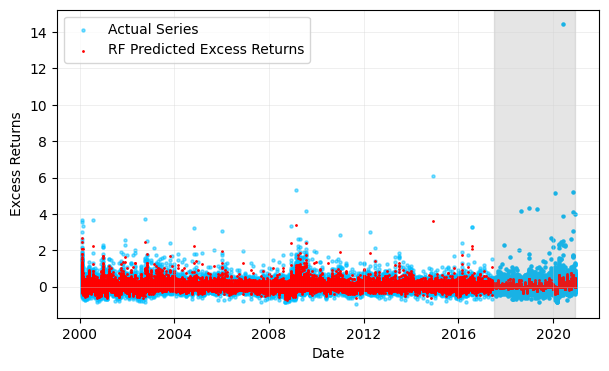

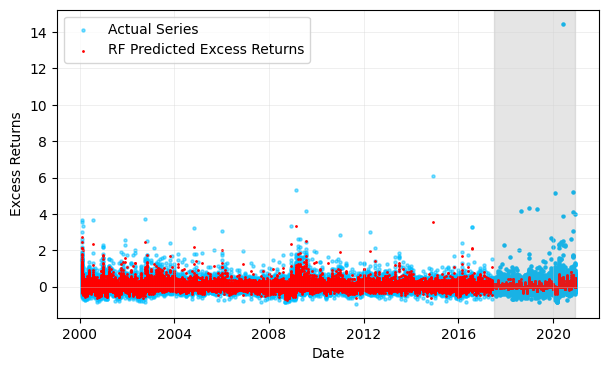

In [14]:
for model_name, model in models.items():
    pl.RF_plot(models, model_name, X_train, X_test, y_train, y_test)

### RF: Evaluation

In [15]:
# Create an empty dictionary to store the evaluation results
evaluation_results = {}

# Loop through the models
for model_name, model in models.items():
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the evaluation results in the dictionary
    evaluation_results[model_name] = {'Mean Squared Error': mse, 'R^2 Score': r2}

In [16]:
# Print the evaluation results
for model_name, results in evaluation_results.items():
    print(f"Evaluation results for {model_name}:")
    #print("Mean Squared Error:", round(results['Mean Squared Error'],4))
    print("R^2 Score:", round(results['R^2 Score'],4))
    print()

Evaluation results for model_150:
R^2 Score: 0.1693

Evaluation results for model_200:
R^2 Score: 0.1729



### RF: Feature importance

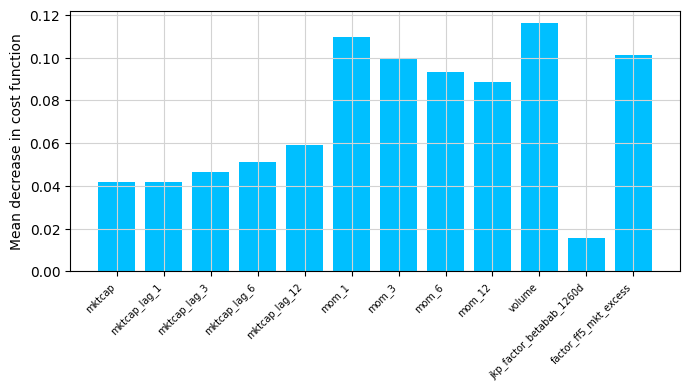

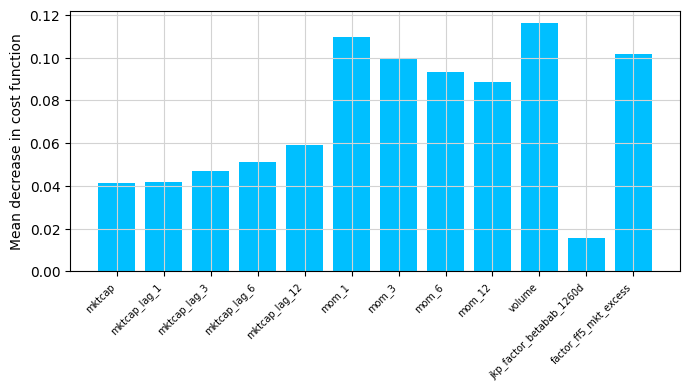

In [17]:
for model_name, model in models.items():
    pl.RF_feature_importances(model, X.columns, model_name, figsize=(7, 4), threshold=0.01)

## Neural Networks

In [18]:
def create_neural_network(layers, neurons, n_features):
    model = keras.Sequential()
    model.add(keras.layers.Dense(neurons[0], activation='relu', input_shape=(n_features,), name='input_layer'))
    
    for i in range(layers):
        model.add(keras.layers.Dense(neurons[i], activation='relu', name=f'hidden_layer_{i+1}'))
    
    model.add(keras.layers.Dense(1, name='output_layer'))  # Output layer
    
    return model

In [19]:
model_1 = create_neural_network(1, [8], n_features)
model_1.compile(optimizer='adam', loss='mean_squared_error')

model_2 = create_neural_network(2, [8,4], n_features)
model_2.compile(optimizer='adam', loss='mean_squared_error')

model_3 = create_neural_network(3, [8,4,2], n_features)
model_3.compile(optimizer='adam', loss='mean_squared_error')

model_4 = create_neural_network(4, [64,32,16,8], n_features)
model_4.compile(optimizer='adam', loss='mean_squared_error')

model_5 = create_neural_network(5, [64,32,16,8,4], n_features)
model_5.compile(optimizer='adam', loss='mean_squared_error')

model_6 = create_neural_network(6, [128,64,32,16,8,4], n_features)
model_6.compile(optimizer='adam', loss='mean_squared_error')


In [20]:
def NN(model, X_train, y_train, X_test, y_test):
    start = time.time()
    history = model.fit(X_train, y_train, epochs=50, verbose = 0,  batch_size=32, validation_split=0.2)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate R^2 score and MSPE
    r2 = r2_score(y_test, y_pred)
    #mspe = mean_squared_error(y_test, y_pred)
    print(" Out-of-sample R^2:", round(r2,4))
    #print("Mean Squared Prediction Error (MSPE):", round(mspe,4))
    
    end = time.time()
    print(f'{round(end - start,3)/60} minutes')
models_NN = [model_1, model_2, model_3, model_4, model_5, model_6]
model_names_NN = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']

In [21]:
for model in models_NN:
    NN(model, X_train, y_train, X_test, y_test)


2094/2094 [==============================] - 3s 2ms/step
 Out-of-sample R^2: 0.1032
18.159716666666668 minutes
2094/2094 [==============================] - 4s 2ms/step
 Out-of-sample R^2: 0.1665
19.49605 minutes
2094/2094 [==============================] - 4s 2ms/step
 Out-of-sample R^2: 0.1527
20.308566666666664 minutes
2094/2094 [==============================] - 3s 2ms/step
 Out-of-sample R^2: 0.1438
20.42096666666667 minutes
2094/2094 [==============================] - 4s 2ms/step
 Out-of-sample R^2: 0.1592
21.86995 minutes
2094/2094 [==============================] - 4s 2ms/step
 Out-of-sample R^2: 0.1468
16.4234 minutes


### NN Plots

10418/10418 [==============================] - 17s 2ms/step


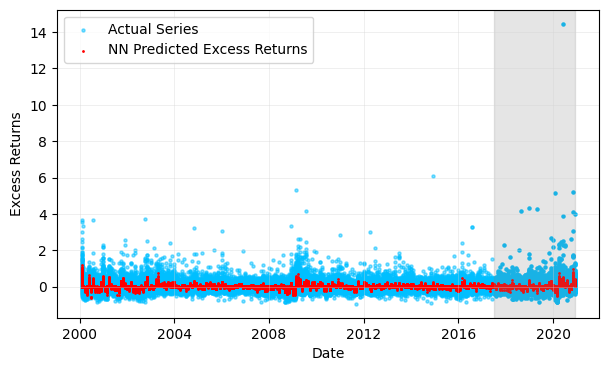

10418/10418 [==============================] - 20s 2ms/step


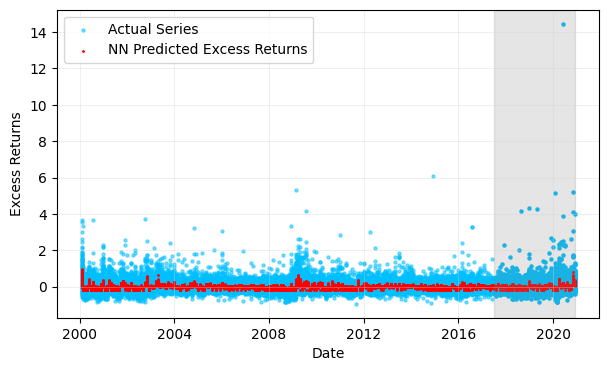

10418/10418 [==============================] - 19s 2ms/step


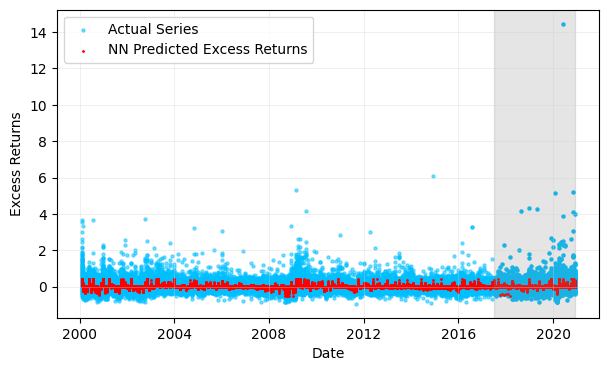

10418/10418 [==============================] - 17s 2ms/step


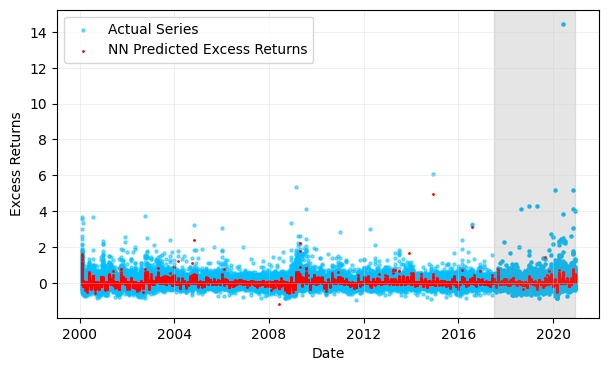

10418/10418 [==============================] - 17s 2ms/step


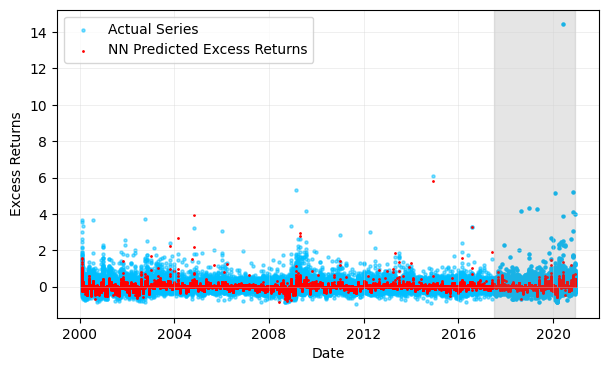

10418/10418 [==============================] - 17s 2ms/step


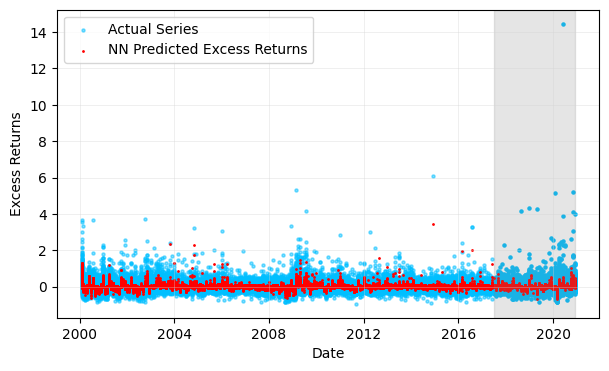

In [22]:
for model, model_name in zip(models_NN, model_names_NN):
    pl.NN_plot(model, model_name, X_train, X_test, y_train, y_test)

### Feature importance

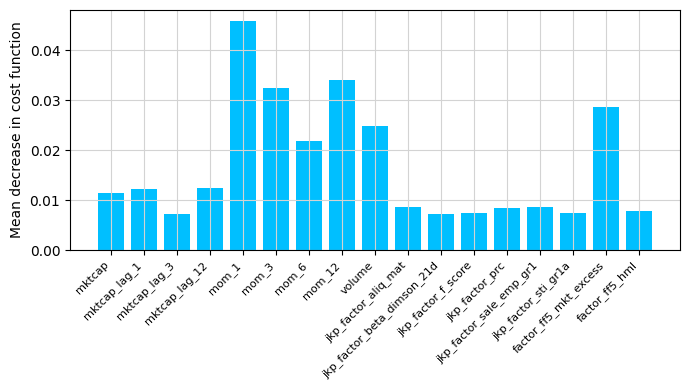

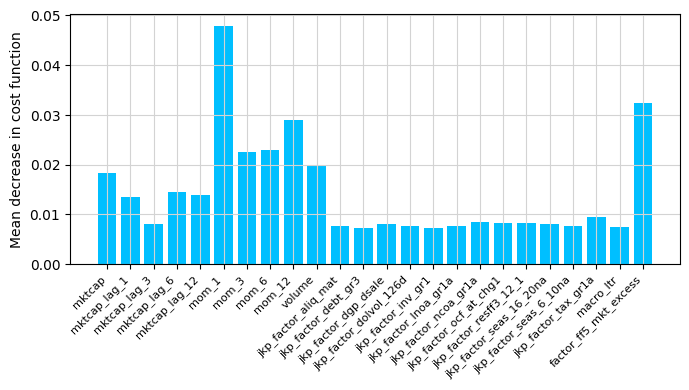

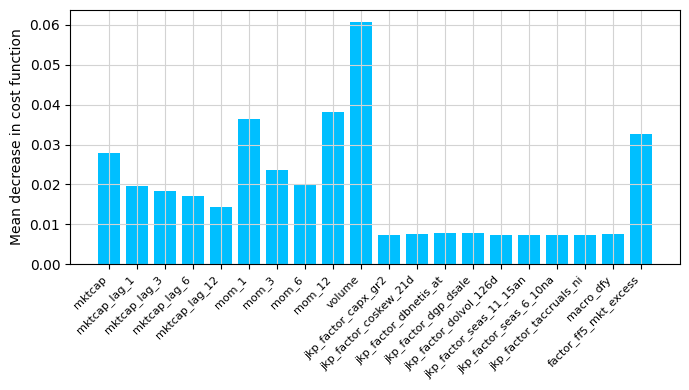

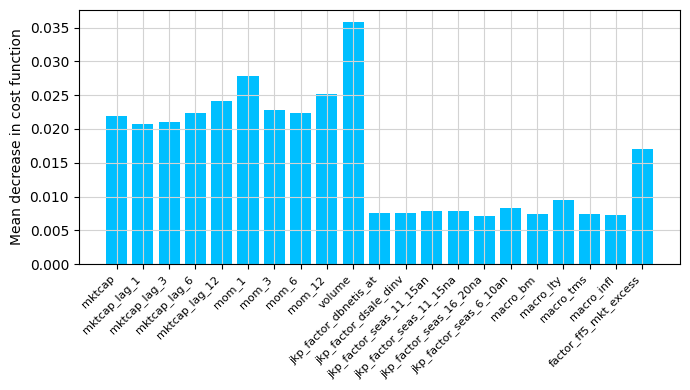

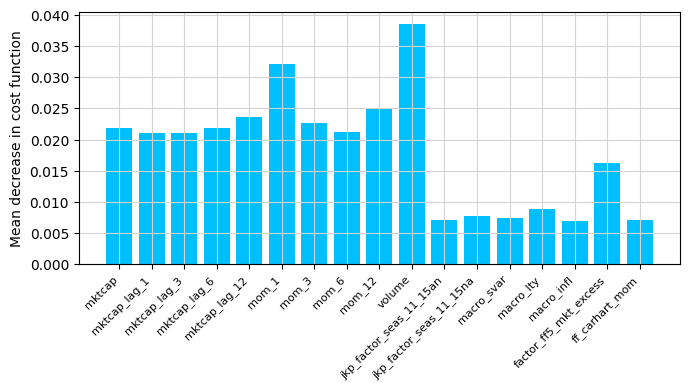

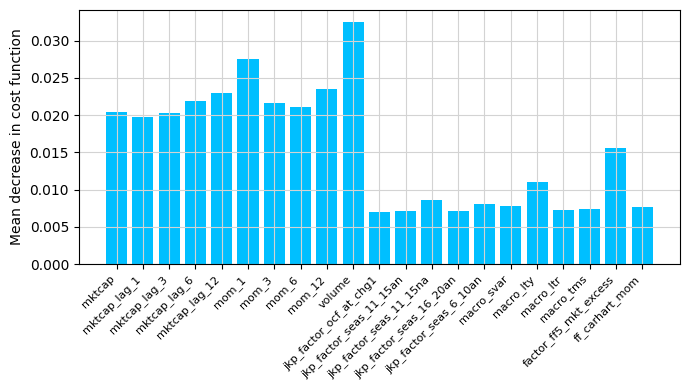

In [23]:
for model, model_name in zip(models_NN, model_names_NN):
    pl.NN_feature_importance(model, feature_names, model_name, threshold=0.007, figsize=(7, 4))